# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from dateutil.parser import parse
%matplotlib inline

# Import dataset

In [2]:
#Data collected for all approaches <=10 LD, no H limit
fname ='cneos_closeapproach_data_future.csv'

df = pd.read_csv(fname)
df.head()

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),CA Distance Minimum (LD | au),V relative (km/s),V infinity (km/s),H (mag),Estimated Diameter,Unnamed: 8
0,(2020 WT1),2020-Nov-21 01:16 ± < 00:01,4.77 | 0.01226,4.76 | 0.01224,17.20,17.19,26.6,13 m - 29 m,bK20W01T
1,(2020 VR2),2020-Nov-21 05:00 ± < 00:01,5.97 | 0.01534,5.94 | 0.01525,6.58,6.56,27.1,10.0 m - 22 m,bK20V02R
2,(2020 WN),2020-Nov-23 02:29 ± < 00:01,4.35 | 0.01117,4.33 | 0.01113,11.31,11.28,27.8,7.5 m - 17 m,bK20W00N
3,(2020 WC),2020-Nov-23 13:49 ± < 00:01,4.18 | 0.01073,4.17 | 0.01071,6.26,6.23,27.5,8.3 m - 19 m,bK20W00C
4,(2017 WJ16),2020-Nov-24 02:30 ± < 00:01,5.29 | 0.01360,5.29 | 0.01360,4.74,4.70,24.3,37 m - 82 m,bK17W16J


# Check for null values

In [3]:
#3 missing values in the V-infinity column; This is ok because I will ignore this column in my analysis.
#this because the V-infinty is the velocity of the object relative to a massless earth, while the V-relative 
#considers the earth mass. 

#CA distance nominal is the most likely closest approach to earth
#CA minimum is the closest possible approach. 
#H magnitude is magnitude of object at 1 AU from sun AND from Observer (Earth)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Object                         3332 non-null   object 
 1   Close-Approach (CA) Date       3332 non-null   object 
 2   CA Distance Nominal (LD | au)  3332 non-null   object 
 3   CA Distance Minimum (LD | au)  3332 non-null   object 
 4   V relative (km/s)              3332 non-null   float64
 5   V infinity (km/s)              3329 non-null   float64
 6   H (mag)                        3332 non-null   float64
 7   Estimated Diameter             3332 non-null   object 
 8   Unnamed: 8                     3332 non-null   object 
dtypes: float64(3), object(6)
memory usage: 234.4+ KB


# Clean data

In [4]:
#Initialize lists
CA_nom_LD = []
CA_nom_AU = []

CA_min_LD = []
CA_min_AU = []

ED_min = []
ED_max = []
ED_unit = []

mean_diam = []
punct = string.punctuation

#formatting for distance data needs to be changed in order to conduct analyses. The distance are separated into two columns,
#lunar distance (LD) and astronomical units (AU)
#1 lunar distance = 384,000 kilometers
#1 AU = 149,597,870 km
for i in range(0,df.shape[0]):
    lst = df['CA Distance Nominal (LD | au)'][i].split()
    CA_nom_LD.append(np.float(lst[0]))
    CA_nom_AU.append(np.float(lst[2]))
    
for i in range(0,df.shape[0]):
    lst = df['CA Distance Minimum (LD | au)'][i].split()
    CA_min_LD.append(np.float(lst[0]))
    CA_min_AU.append(np.float(lst[2]))

#Some diamater estimates are in km. Keeping units consistent will make the analysis easier later on so the following loop
#looks for units in km and converts them to meters in addition to changing the unit string. 
for i in range(0,df.shape[0]):
    #create list of objects by splitting each line the estimated diameter df
    lst = df['Estimated Diameter'][i].split()
    index=[]
    if 'km' in lst:
        #find index(s) where km appears in the split list
        for j,val in enumerate(lst):
            if val =='km':
                index.append(j)
        #the number allways precedes the unit so if 'km' is found, the number at the index-1 position is converted to
        #meters
        for k in range(len(index)):
            lst[index[k]-1] = np.float(lst[index[k]-1])*1000
            lst[index[k]]='m'
    ED_min.append(np.float(lst[0])) 
    ED_max.append(np.float(lst[3]))
    ED_unit.append(lst[1])
    mean_diam.append((ED_min[i]+ED_max[i])/2.)

#Date-times are in a weird format and contain the uncertainty in time so I needed to parse them such that 
#I can use a standard library like np.datetime64 to analize them. 
datetime=[]
uncertainty = []
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_num = ['01','02','03','04','05','06','07','08','09','10','11','12']

for i in range(0,df.shape[0]):
    lst = df['Close-Approach (CA) Date'][i].split()
    a = lst[0]
    b = a.split('-')
    for j,val in enumerate(months):
        if b[1]==val:
            b[1]= month_num[j]
    c=b[0]+'-'+b[1]+'-'+b[2]+'T'+lst[1]
    datetime.append(np.datetime64(c))
    if len(lst)==4:
        uncertainty.append(lst[3])
    else:
        uncertainty.append(lst[4])

#Uncertainties are given in the form of Days_hours:minutes. I needed to convert these to days:hours:minutes
for i in range(len(uncertainty)):
    a=uncertainty[i]
    for val in punct:
        a=a.replace(val,':')
    b=a.split(':')
    if len(b)==2:
        a='00'+':'+b[0]+':'+b[1]
    uncertainty[i]=a

#clean up punctuation in object id
OBJ = []

for i in range(0,df.shape[0]):
    a = df['Object'][i]
    for val in punct:
        a=a.replace(val,'')
    OBJ.append(a)

# Create cleaned dataset

In [5]:
df_cleaned = pd.DataFrame({'Object': OBJ,'Close-Approach (CA) Date': datetime,'CA uncertainty': uncertainty,
                          'CA Distance Nominal (LD)': CA_nom_LD,'CA Distance Nominal (AU)': CA_nom_AU,
                          'CA Distance Minimum (LD)': CA_min_LD,'CA Distance Minimum (AU)': CA_min_AU,
                          'V relative (km/s)': df['V relative (km/s)'], 'Estimated min Diam.': ED_min,
                           'Estimated max Diam.': ED_max, 'Mean diam.':mean_diam,'Estimated Diam. unit': ED_unit,
                          'H (mag)':df['H (mag)']})

df_cleaned.head()

,Object,Close-Approach (CA) Date,CA uncertainty,CA Distance Nominal (LD),CA Distance Nominal (AU),CA Distance Minimum (LD),CA Distance Minimum (AU),V relative (km/s),Estimated min Diam.,Estimated max Diam.,Mean diam.,Estimated Diam. unit,H (mag)
0,2020 WT1,2020-11-21 01:16:00,00:00:01,4.77,0.01226,4.76,0.01224,17.20,13.0,29.0,21.00,m,26.6
1,2020 VR2,2020-11-21 05:00:00,00:00:01,5.97,0.01534,5.94,0.01525,6.58,10.0,22.0,16.00,m,27.1
2,2020 WN,2020-11-23 02:29:00,00:00:01,4.35,0.01117,4.33,0.01113,11.31,7.5,17.0,12.25,m,27.8
3,2020 WC,2020-11-23 13:49:00,00:00:01,4.18,0.01073,4.17,0.01071,6.26,8.3,19.0,13.65,m,27.5
4,2017 WJ16,2020-11-24 02:30:00,00:00:01,5.29,0.01360,5.29,0.01360,4.74,37.0,82.0,59.50,m,24.3


# Find unique objects in database and determine number of passes

In [6]:
#How many unique objects are in the NEO database and of the repeats, how many times do they pass the earth by <10LD

Objects = []
passes = []

for val in df_cleaned['Object']:
    if val not in Objects:
        Objects.append(val)
len(Objects)

#for each unique object, count the number of repeated passes by the earth
for j in range(len(Objects)):
    count=0
    for i,val in enumerate(df_cleaned['Object']):
        if Objects[j]==val:
            count+=1
    passes.append(count)
    
#NEO's and the number of close passes
df_objects = pd.DataFrame({'Object': Objects,'Passes':passes})

print('Unique NEOs: %d' %len(Objects))

Unique NEOs: 2147


In [7]:
#Objects and number of passes
df_objects.head()

,Object,Passes
0,2020 WT1,1
1,2020 VR2,1
2,2020 WN,1
3,2020 WC,1
4,2017 WJ16,5


# Size distribution of objects

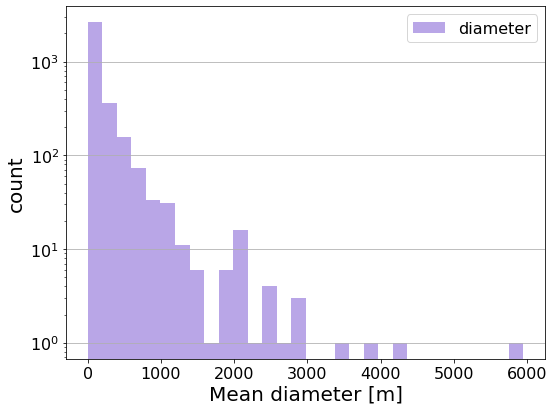

In [8]:
#bin size is 198m
bins = 30
color = '#3900BB'

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df_cleaned['Mean diam.'],alpha=0.35,bins=bins,color=color,label='diameter')
plt.grid(axis='y')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('Mean diameter [m]',fontsize=20)
plt.ylabel('count',fontsize=20);
plt.tight_layout()
plt.savefig('mean_diam.png')

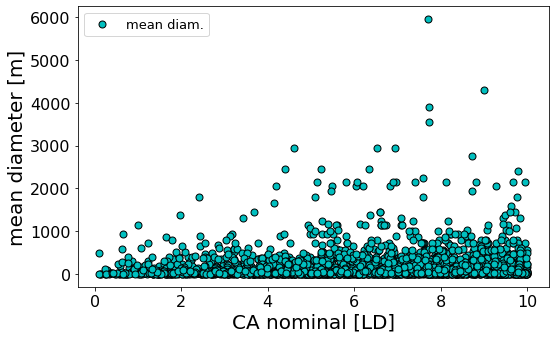

In [9]:
plt.figure(figsize=(8,5))
plt.plot(df_cleaned['CA Distance Nominal (LD)'],df_cleaned['Mean diam.'],'o',
         markersize=7,color='c',label='mean diam.',markeredgecolor='k')
plt.xlabel('CA nominal [LD]',fontsize = 20)
plt.ylabel('mean diameter [m]',fontsize= 20)
plt.legend(loc='best',fontsize=13);
plt.tight_layout()
plt.savefig('mean_diam_CA_nom.png')

# Distribution of closest approaches

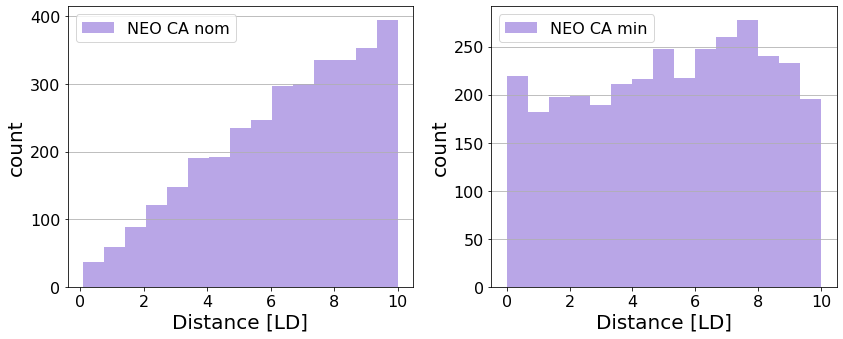

In [10]:
bins = 15

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(df_cleaned['CA Distance Nominal (LD)'],alpha=0.35,bins=bins,label='NEO CA nom',color=color)
plt.grid(axis='y')
#plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Distance [LD]',fontsize=20)
plt.ylabel('count',fontsize=20)

ax1 = fig.add_subplot(1,2,2)
ax1.hist(df_cleaned['CA Distance Minimum (LD)'],alpha=0.35,bins=bins,label='NEO CA min',color=color)
plt.grid(axis='y')
#plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Distance [LD]',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.tight_layout()
#plt.savefig('distances.png')

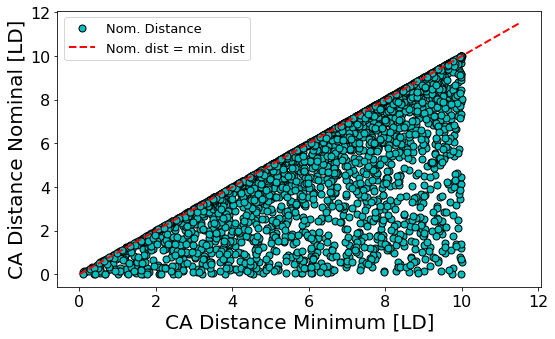

In [11]:
y = np.arange(0,12,0.5)
x = y
plt.figure(figsize=(8,5))
plt.plot(df_cleaned['CA Distance Nominal (LD)'],df_cleaned['CA Distance Minimum (LD)'],'o',
         markersize=7,color='c',label='Nom. Distance',markeredgecolor='k')
plt.plot(x,y, linewidth=2,c='r',linestyle='--',label='Nom. dist = min. dist')
plt.xlabel('CA Distance Minimum [LD]',fontsize = 20)
plt.ylabel('CA Distance Nominal [LD]',fontsize= 20)
plt.legend(loc='best',fontsize=13);
plt.tight_layout()
plt.savefig('nom_min.png')

# Distribution of objects by month

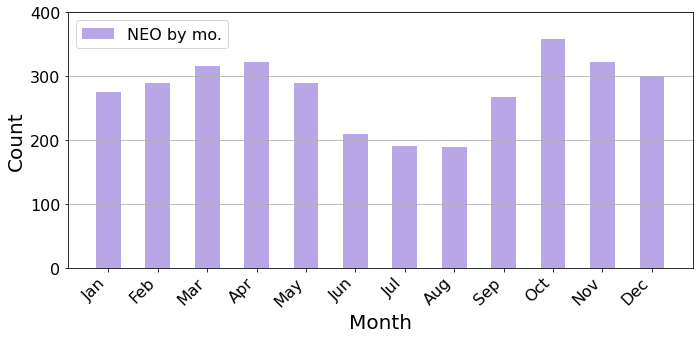

In [12]:
#Create sorted dataframe by month
df_cleaned['month'] = df_cleaned['Close-Approach (CA) Date'].dt.month_name()
df_cleaned['month-number'] = df_cleaned['Close-Approach (CA) Date'].dt.month
df_sort = df_cleaned.sort_values(by=["month-number"], ascending=True)

#Count number of objects grouped by month
grouped_month = df_sort.groupby('month-number')
counts = grouped_month['month-number'].count()
#Count number of objects grouped by mean diameter and by month
mon_mean_diam = grouped_month['Mean diam.'].mean()
#Count number of objects grouped by nominal closest approach and by month
mon_CA = grouped_month['CA Distance Nominal (LD)'].mean()

#Group objects by number of total passes
grouped_passes = df_objects.groupby('Passes')
counts_obj = grouped_passes['Passes'].count()
passes_c = [1,2,3,4,5,6,7,8,9,14,16,22]

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(months,counts,width=.5,alpha=0.35,label='NEO by mo.',color=color)
plt.grid(axis='y')
plt.ylim([0,400])
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend(loc='upper left')
plt.xlabel('Month',fontsize=20)
plt.ylabel('Count',fontsize=20);
plt.tight_layout()
plt.savefig('countbymo.png')

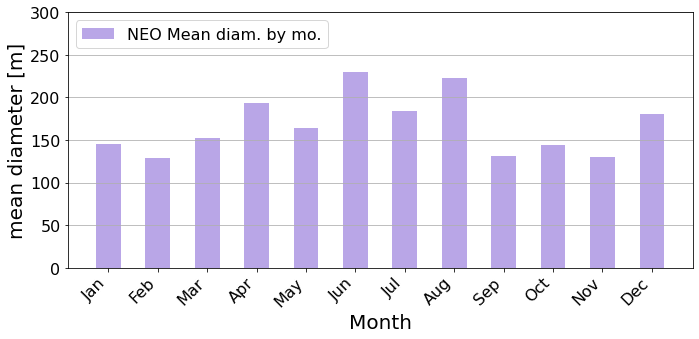

In [13]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(months,mon_mean_diam,width=.5,alpha=0.35,label='NEO Mean diam. by mo.',color=color)
plt.grid(axis='y')
plt.ylim([0,300])
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend(loc='upper left')
plt.xlabel('Month',fontsize=20)
plt.ylabel('mean diameter [m]',fontsize=20);
plt.tight_layout()
plt.savefig('mean_diam_mo.png')

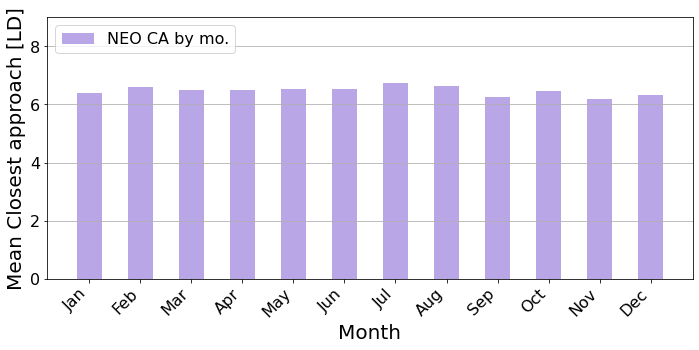

In [14]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(months,mon_CA,width=.5,alpha=0.35,label='NEO CA by mo.',color=color)
plt.grid(axis='y')
plt.ylim([0,9])
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend(loc='upper left')
plt.xlabel('Month',fontsize=20)
plt.ylabel('Mean Closest approach [LD]',fontsize=20);
plt.tight_layout()
plt.savefig('CA_mo.png')

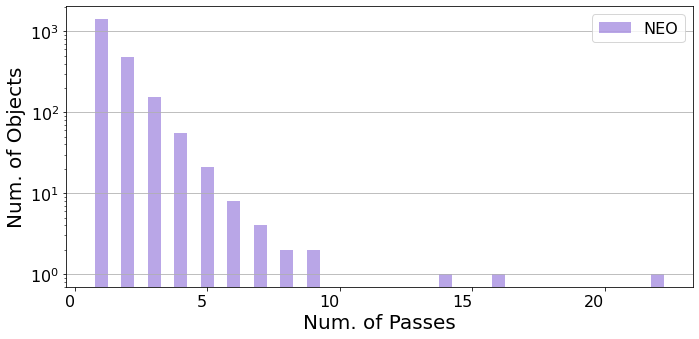

In [15]:
# 
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(passes_c,counts_obj,width=0.5,alpha=0.35,label='NEO',color=color)
plt.grid(axis='y')
plt.yscale('log')
plt.xticks(horizontalalignment='right')
plt.legend(loc='upper right')
plt.xlabel('Num. of Passes',fontsize=20)
plt.ylabel('Num. of Objects',fontsize=20);
plt.tight_layout()
plt.savefig('numpasses.png')

# Number of objects per decade

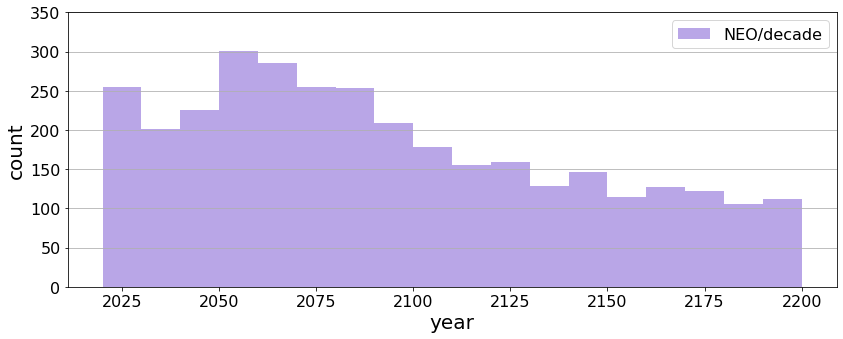

In [16]:
df_cleaned['year'] = df_cleaned['Close-Approach (CA) Date'].dt.year

nbins =18

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df_cleaned['year'],alpha=0.35,color=color,bins=nbins,label='NEO/decade')
plt.grid(axis='y')
plt.ylim([0,350])
plt.legend(loc='best')
plt.xlabel('year',fontsize=20)
plt.ylabel('count',fontsize=20);
plt.tight_layout()
plt.savefig('countbyyr.png')

# Relative velocity v. object CA distance

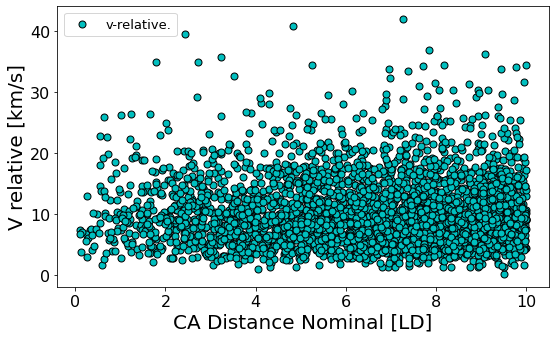

In [17]:
plt.figure(figsize=(8,5))
plt.plot(df_cleaned['CA Distance Nominal (LD)'],df_cleaned['V relative (km/s)'],'o',
         markersize=7,color='c',label='v-relative.',markeredgecolor='k')
plt.xlabel('CA Distance Nominal [LD]',fontsize = 20)
plt.ylabel('V relative [km/s]',fontsize= 20)
plt.legend(loc='upper left',fontsize=13);
plt.tight_layout()
plt.savefig('v-relative_min.png')

# Group objects by absolute visual magnitude

In [18]:
bins2 = np.arange(df_cleaned['H (mag)'].min()-0.3,df_cleaned['H (mag)'].max()+1.7,1)
bin_avg = []
for i in range(len(bins2)-1):
    bin_avg.append((bins2[i]+bins2[i+1])/2.)

condi = (df_cleaned['H (mag)']>=20) & (df_cleaned['H (mag)']<21)
df_cleaned[condi]

Obj_count = []

for i in range(len(bins2)-1):
    condi = (df_cleaned['H (mag)']>=bins2[i]) & (df_cleaned['H (mag)']<bins2[i+1])
    Obj_count.append(df_cleaned[condi].count()[0])

#Number of NEOs per unit of absolute magnitude
df_Hmag = pd.DataFrame({'H-mag': bin_avg,'Count':Obj_count})
df_Hmag

,H-mag,Count
0,14.5,1
1,15.5,6
2,16.5,28
3,17.5,35
4,18.5,86
5,19.5,150
6,20.5,245
7,21.5,239
8,22.5,280
9,23.5,266


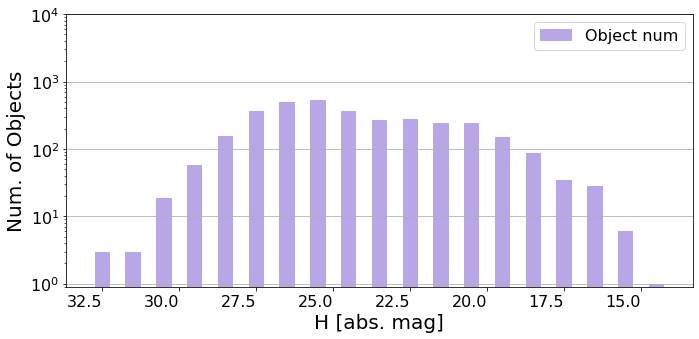

In [19]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_Hmag['H-mag'],df_Hmag['Count'],width=0.5,alpha=0.35,label='Object num',color=color)
plt.grid(axis='y')
ax1.invert_xaxis()
plt.ylim([0.9,10000])
plt.yscale('log')
plt.xticks(horizontalalignment='right')
plt.legend(loc='upper right')
plt.xlabel('H [abs. mag]',fontsize=20)
plt.ylabel('Num. of Objects',fontsize=20);
plt.tight_layout()
plt.savefig('H-mags.png')

# Find all objects with CA <= 1 LD

In [20]:
conition_2 = df_cleaned['CA Distance Nominal (LD)']<=1
close_pass = df_cleaned[conition_2]
close_pass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 8 to 3217
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Object                    56 non-null     object        
 1   Close-Approach (CA) Date  56 non-null     datetime64[ns]
 2   CA uncertainty            56 non-null     object        
 3   CA Distance Nominal (LD)  56 non-null     float64       
 4   CA Distance Nominal (AU)  56 non-null     float64       
 5   CA Distance Minimum (LD)  56 non-null     float64       
 6   CA Distance Minimum (AU)  56 non-null     float64       
 7   V relative (km/s)         56 non-null     float64       
 8   Estimated min Diam.       56 non-null     float64       
 9   Estimated max Diam.       56 non-null     float64       
 10  Mean diam.                56 non-null     float64       
 11  Estimated Diam. unit      56 non-null     object        
 12  H (mag)               

In [21]:
close_pass.head()

,Object,Close-Approach (CA) Date,CA uncertainty,CA Distance Nominal (LD),CA Distance Nominal (AU),CA Distance Minimum (LD),CA Distance Minimum (AU),V relative (km/s),Estimated min Diam.,Estimated max Diam.,Mean diam.,Estimated Diam. unit,H (mag),month,month-number,year
8,2020 SO,2020-12-01 08:53:00,00:00:02,0.13,0.00034,0.13,0.00034,3.90,4.6,10.0,7.3,m,28.8,December,12,2020
18,2020 SO,2021-02-02 20:29:00,00:00:26,0.59,0.00151,0.59,0.00151,1.78,4.6,10.0,7.3,m,28.8,February,2,2021
210,153814 2001 WN5,2028-06-26 05:23:00,00:00:01,0.65,0.00166,0.65,0.00166,10.24,580.0,1300.0,940.0,m,18.3,June,6,2028
236,99942 Apophis 2004 MN4,2029-04-13 21:46:00,00:00:01,0.10,0.00025,0.10,0.00025,7.43,310.0,680.0,495.0,m,19.7,April,4,2029
250,2001 AV43,2029-11-11 15:25:00,00:00:03,0.81,0.00209,0.81,0.00209,4.00,32.0,71.0,51.5,m,24.6,November,11,2029


# Plot all objects passing within 1 LD and scale points by mean diameter

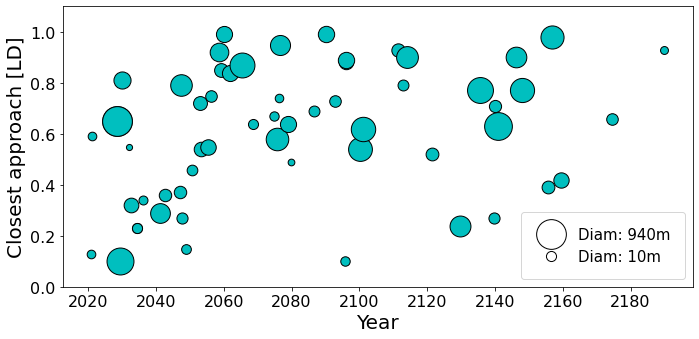

In [22]:
sizes = close_pass['Mean diam.'].values
CS_dt = close_pass['Close-Approach (CA) Date'].values
CS_dist = close_pass['CA Distance Nominal (LD)'].values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plt.plot(CS_dt[2],CS_dist[2],'o',c='w',markeredgecolor='k',markersize=10*np.log10(sizes[2]),label = 'Diam: 940m')
plt.plot(CS_dt[7],CS_dist[7],'o',c='w',markeredgecolor='k',markersize=10*np.log10(sizes[7]),label = 'Diam: 10m')
for i in range(len(sizes)):
    plt.plot(CS_dt[i],CS_dist[i],'o',c='c',markeredgecolor='k',markersize=10*np.log10(sizes[i]))
ax.set_ylim([0,1.1])
ax.set_ylabel('Closest approach [LD]',fontsize=20)
ax.set_xlabel('Year',fontsize=20);
plt.legend(loc='best',borderpad=1,fontsize = 15)
plt.tight_layout()
plt.savefig('Close_passes.png')

In [23]:
a=df_cleaned['CA Distance Nominal (LD)']<=0.5
df_cleaned[a].count()

Object                      17
Close-Approach (CA) Date    17
CA uncertainty              17
CA Distance Nominal (LD)    17
CA Distance Nominal (AU)    17
CA Distance Minimum (LD)    17
CA Distance Minimum (AU)    17
V relative (km/s)           17
Estimated min Diam.         17
Estimated max Diam.         17
Mean diam.                  17
Estimated Diam. unit        17
H (mag)                     17
month                       17
month-number                17
year                        17
dtype: int64